<a href="https://colab.research.google.com/github/khuzin-e/mipt-sem2-python-lab/blob/main/lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [152]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [153]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [154]:
data.keys()


dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [155]:
URL = 'https://api.hh.ru/vacancies'

professions = ["Курьер", "Кассир", "Оператор", "Водитель", "Сварщик"]
vacancies = dict()

params = {
  'text': "",
  'area': 1,
  'per_page': 100
}
for prof in professions:
  params['text'] = prof 
  data = requests.get(URL, params).json()
  vacancies[prof] = list()
  for j in range(data['pages']):
    params['page'] = j
    data = requests.get(URL, params).json()
    vacancies[prof].extend(x for x in data['items'])


In [156]:
# for prof in professions:
#   print(prof)
#   for vac in vacancies[prof]:
#     print(vac)

(1 балл) Посчитайте сколько всего найдено вакансий:

In [157]:
noof_vacancies = sum(len(v) for v in vacancies.values())

In [158]:
print(noof_vacancies)

8513


(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [159]:
class Coord:
  def __init__(self, latitude, longitude):
    self.latitude = latitude
    self.longitude = longitude

class Company:
  def __init__(self, name, latitude, longitude):
    self.name = name
    self.coord = Coord(latitude, longitude)


(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [160]:
companies = set()
for prof in vacancies:
  for vac in vacancies[prof]:
    name = str(vac['employer']['name']) if vac['employer'] != None else "None"
    latitude = float(vac['address']['lat']) if vac['address'] != None and vac['address']['lat'] != None else None
    longitude = float(vac['address']['lng']) if vac['address'] != None and vac['address']['lng'] != None else None
    company = Company(name, latitude, longitude)
    companies.add(company)

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [161]:
count = 0
for lst in vacancies.values():
  count += sum(int(vac['lat'] != None and vac['lng'] != None) for vac in [l['address'] for l in lst if l['address'] != None])
print(count)

5809


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [162]:
from geopy.distance import geodesic 

mkad_vac = []
center = (55.752919, 37.626941)
radius = 17.0
for lst in vacancies.values():
    for vac in [l['address'] for l in lst if l['address'] != None]:
        if vac['lat'] != None and vac['lng'] != None:
            coords = (vac['lat'], vac['lng'])
            dist = geodesic(center, coords).km
            if (dist <= radius):
                mkad_vac.append(vac)
print(len(mkad_vac))

4550


(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

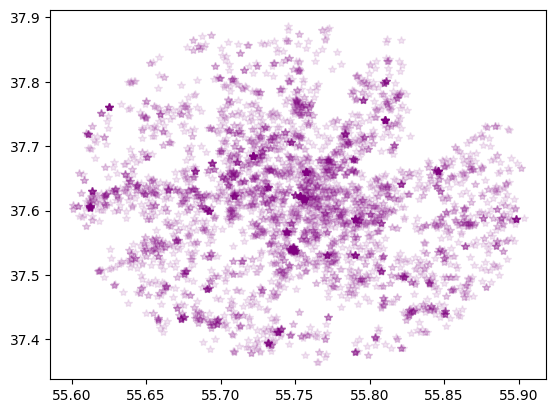

In [163]:
x = [vac['lat'] for vac in mkad_vac]
y = [vac['lng'] for vac in mkad_vac]
plt.plot(x, y, color='purple', marker='*', alpha=0.1, linewidth=0)
plt.show()

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве): 

In [164]:
import plotly.express as px

map_box = px.scatter_mapbox(lat = x, lon = y, center={'lat' : center[0], 'lon' : center[1]}, zoom=10, height=800)

map_box.update_layout(mapbox_style="open-street-map")
map_box.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
map_box.show()


(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Вакансий практически нет в парках и их количество уменьшается к окрайнам Москвы.
И большинство (очень фиолетово) вакансий находится в центре.

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [165]:
!gdown 1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU

Downloading...
From: https://drive.google.com/uc?id=1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 207MB/s]


Создадим DataFrame:

In [166]:
diamonds = pd.read_csv("diamonds.csv")

(0.5 балла) Выведете первые 5 строк датасета:

In [167]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [168]:
diamonds.shape[0]

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [169]:
mi = diamonds['total_sales_price'].min()
ma = diamonds['total_sales_price'].max()
print(diamonds.index[diamonds['total_sales_price'] == mi][0], mi, sep='\t')
print(diamonds.index[diamonds['total_sales_price'] == ma][0], ma, sep='\t')

0	200
219702	1449881


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [170]:
diamonds.replace(['unknown', 'None'], pd.NA, inplace=True)
diamonds.isnull().sum().sum()

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [171]:
empty_col = [col for col in diamonds.columns if diamonds[col].isnull().sum() != 0]
print(empty_col)

['color', 'cut_quality', 'eye_clean', 'culet_size', 'culet_condition', 'girdle_min', 'girdle_max', 'fluor_color', 'fluor_intensity', 'fancy_color_dominant_color', 'fancy_color_secondary_color', 'fancy_color_overtone', 'fancy_color_intensity']


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными. 

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [172]:
count = len([col for col in diamonds.columns if any([col[0:12] == "fancy_color_", col[0:6] == "fluor_"])])
print(count)

6


2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках: 

In [173]:
s = sum(diamonds.shape[0] - diamonds[col].isnull().sum() for col in diamonds.columns if any([col[0:12] == "fancy_color_", col[0:6] == "fluor_"]))
print(s)

111586


3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [174]:
all = [col for col in diamonds.columns if any([col[0:12] == "fancy_color_", col[0:6] == "fluor_"])]
diamonds.drop(columns = all, axis=1, inplace=True)

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [175]:
all = [col for col in diamonds.columns if col[0:6] == "culet_"]
diamonds.drop(columns = all, axis=1, inplace=True)

(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [176]:
round(diamonds['total_sales_price'].sum() / 1000 + 0.5)

1517722

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [177]:
diamonds[::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,<NA>,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,<NA>,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,<NA>,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,<NA>,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,<NA>,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,<NA>,62.1,58.0,14.84,14.91,9.24,<NA>,<NA>,1121792
219696,219697,Oval,H,VS2,18.88,<NA>,GIA,Excellent,Excellent,<NA>,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,<NA>,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,<NA>,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [178]:
diamonds[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,<NA>,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,<NA>,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,<NA>,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,<NA>,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,<NA>,0.0,0.0,0.00,0.00,0.00,<NA>,<NA>,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,<NA>,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,<NA>,I1,0.89,<NA>,GIA,Good,Good,<NA>,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,<NA>,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,<NA>,GIA,Excellent,Excellent,<NA>,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [179]:
diamonds.select_dtypes(include='object')

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,<NA>,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,<NA>,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,<NA>,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,<NA>,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,<NA>,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,<NA>,M,STK
219699,Radiant,<NA>,VS2,<NA>,GIA,Very Good,Very Good,<NA>,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,<NA>,TN,M
219701,Princess,<NA>,SI2,<NA>,GIA,Good,Good,<NA>,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [180]:
# col = diamonds['total_sales_price'].to_numpy()
col = np.array([1, 2, 3])
# оригинальная col is too big
# для умножения столбца на строчку и получения матрицы
col = col.reshape(1, col.shape[0])
print(np.matmul(col.transpose(), col))

[[1 2 3]
 [2 4 6]
 [3 6 9]]


### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

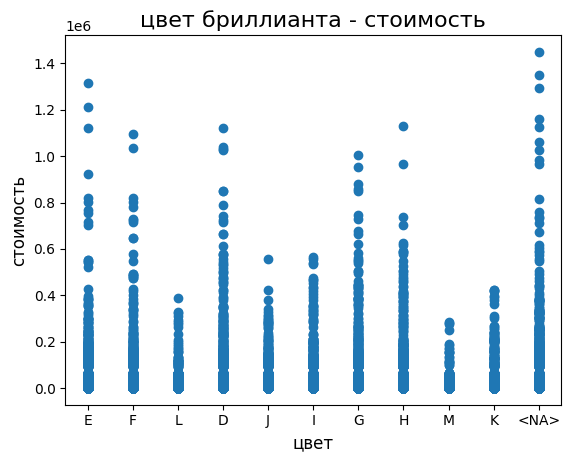

In [181]:
plt.title('цвет бриллианта - стоимость', fontsize=16)

plt.scatter(
  diamonds['color'].astype(str),
  diamonds['total_sales_price'].astype(float),
)
plt.xlabel('цвет', fontdict=dict(size=12))
plt.ylabel('стоимость', fontdict=dict(size=12))
plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

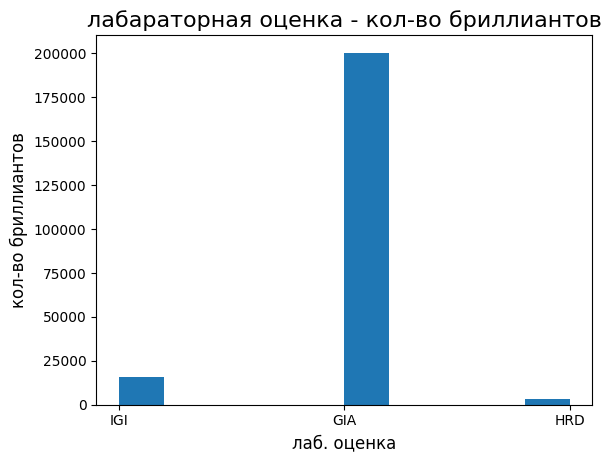

In [182]:
plt.title('лабараторная оценка - кол-во бриллиантов', fontsize=16)

plt.hist(diamonds['lab'])
plt.xlabel('лаб. оценка', fontdict=dict(size=12))
plt.ylabel('кол-во бриллиантов', fontdict=dict(size=12))
plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

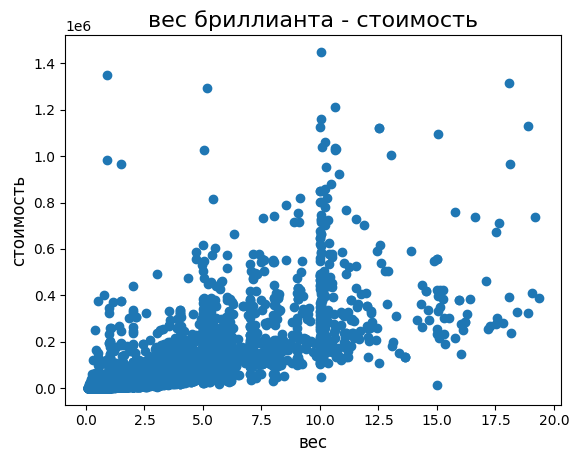

In [183]:
plt.title('вес бриллианта - стоимость', fontsize=16)

plt.scatter(
  diamonds['carat_weight'],
  diamonds['total_sales_price'],
)
plt.xlabel('вес', fontdict=dict(size=12))
plt.ylabel('стоимость', fontdict=dict(size=12))
plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

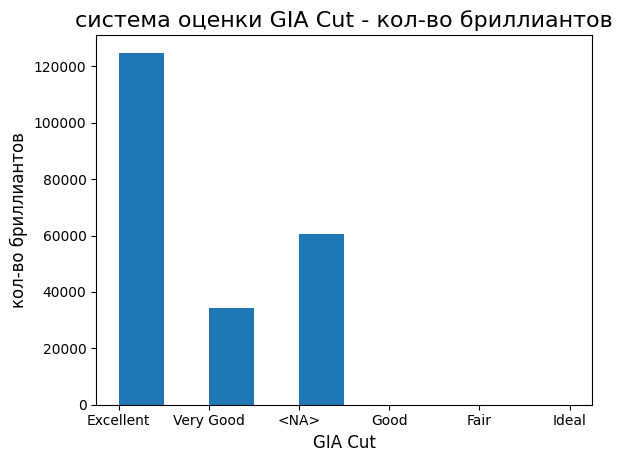

In [184]:
plt.title('система оценки GIA Cut - кол-во бриллиантов', fontsize=16)

plt.hist(
  diamonds['cut_quality'].astype(str),
)
plt.xlabel('GIA Cut', fontdict=dict(size=12))
plt.ylabel('кол-во бриллиантов', fontdict=dict(size=12))
plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

1. Камней с огранкой <= Good нет
2. Есть дешёвые тяжелые бриллианты, значит вес - это не единственный фактор формирования цены



## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно: 
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк: 

In [185]:
ds = diamonds[['total_sales_price', 'meas_length', 'meas_width', 'meas_depth']]
ds.head(10)

,total_sales_price,meas_length,meas_width,meas_depth
0,200,2.85,2.87,1.79
1,200,2.84,2.89,1.78
2,200,2.88,2.90,1.77
3,200,2.86,2.88,1.78
4,200,2.79,2.83,1.82
5,200,2.95,2.99,1.81
6,200,2.85,2.88,1.84
7,200,2.86,2.89,1.78
8,200,2.89,2.92,1.85
9,200,2.83,2.87,1.80


(1 балл) Перемешайте строки в датафрейме случайным образом: 

In [186]:
ds = ds.sample(frac=1)

In [187]:
print(ds)

        total_sales_price  meas_length  meas_width  meas_depth
113494               2160         4.89        3.81        2.83
166023               5556         6.34        6.38        3.97
35109                 832         4.33        4.35        2.67
231                   324         6.12        3.89        2.25
63848                1012         3.84        3.76        2.83
...                   ...          ...         ...         ...
98414                1522         4.71        4.73        2.80
37463                 858         4.29        4.34        2.59
125363               2610         5.14        5.17        3.21
155807               4032         5.49        5.57        3.57
61525                 996         4.35        4.36        2.67

[219703 rows x 4 columns]


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [188]:
ds['mink_sum'] = (
  abs(ds['meas_length'] - ds['meas_width']) ** 3
  + abs(ds['meas_length'] - ds['meas_depth']) ** 3
  + abs(ds['meas_depth'] - ds['meas_width']) ** 3
  ) ** (1/3)

In [189]:
print(ds)


        total_sales_price  meas_length  meas_width  meas_depth  mink_sum
113494               2160         4.89        3.81        2.83  2.220113
166023               5556         6.34        6.38        3.97  3.011425
35109                 832         4.33        4.35        2.67  2.104144
231                   324         6.12        3.89        2.25  4.188121
63848                1012         3.84        3.76        2.83  1.224312
...                   ...          ...         ...         ...       ...
98414                1522         4.71        4.73        2.80  2.419114
37463                 858         4.29        4.34        2.59  2.173829
125363               2610         5.14        5.17        3.21  2.450694
155807               4032         5.49        5.57        3.57  2.470501
61525                 996         4.35        4.36        2.67  2.122986

[219703 rows x 5 columns]


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`: 

In [190]:
new_ds = ds[['mink_sum', 'total_sales_price']]

In [191]:
print(new_ds)

        mink_sum  total_sales_price
113494  2.220113               2160
166023  3.011425               5556
35109   2.104144                832
231     4.188121                324
63848   1.224312               1012
...          ...                ...
98414   2.419114               1522
37463   2.173829                858
125363  2.450694               2610
155807  2.470501               4032
61525   2.122986                996

[219703 rows x 2 columns]


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [192]:
test_ds = new_ds[:new_ds.shape[0] * 8 // 10]
train_ds = new_ds[new_ds.shape[0] * 8 // 10:]

In [193]:
print(test_ds)
print(train_ds)

        mink_sum  total_sales_price
113494  2.220113               2160
166023  3.011425               5556
35109   2.104144                832
231     4.188121                324
63848   1.224312               1012
...          ...                ...
154583  2.645899               4108
32825   2.053749                842
174568  6.333252               7100
133828  2.331974               3020
91135   2.425497               1356

[175762 rows x 2 columns]
        mink_sum  total_sales_price
173648  2.942590               6470
71336   1.997156               1062
108351  2.519906               1946
48832   2.387567                928
76772   2.003354               1116
...          ...                ...
98414   2.419114               1522
37463   2.173829                858
125363  2.450694               2610
155807  2.470501               4032
61525   2.122986                996

[43941 rows x 2 columns]


(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

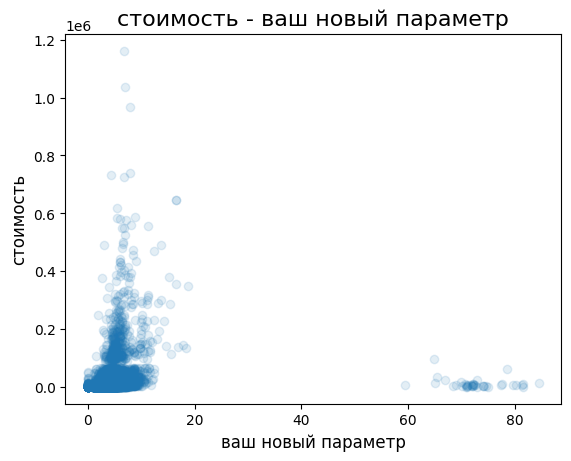

In [194]:
plt.title('стоимость - ваш новый параметр', fontsize=16)

plt.scatter(
  train_ds['mink_sum'],
  train_ds['total_sales_price'],
  alpha = 0.12
)
plt.xlabel('ваш новый параметр', fontdict=dict(size=12))
plt.ylabel('стоимость', fontdict=dict(size=12))

plt.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

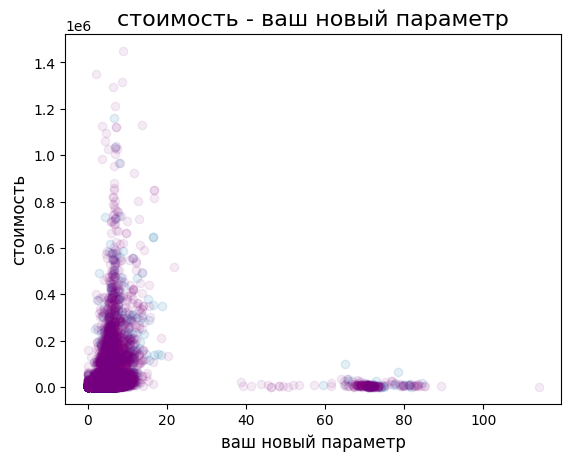

In [195]:
plt.title('стоимость - ваш новый параметр', fontsize=16)

plt.scatter(
  train_ds['mink_sum'],
  train_ds['total_sales_price'],
  alpha = 0.12
)
plt.scatter(
  test_ds['mink_sum'],
  test_ds['total_sales_price'],
  alpha = 0.08,
  color='purple'
)
plt.xlabel('ваш новый параметр', fontdict=dict(size=12))
plt.ylabel('стоимость', fontdict=dict(size=12))

plt.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [196]:
num = list()
closest = list()
distance = list()
price_difference = list()

def dist(row_lhs, row_rhs):
  return ((row_lhs['mink_sum'] - row_rhs['mink_sum']) ** 2 + (row_lhs['total_sales_price'] - row_rhs['total_sales_price']) ** 2) ** (1/2)

def diff(row_lhs, row_rhs):
  return 100 * abs(row_lhs['total_sales_price'] - row_rhs['total_sales_price']) / row_rhs['total_sales_price'] 

too_much_diamonts = 5
cnt = 0

for idx, row in test_ds.iterrows():
  min_dist = 1e32
  closest_neigh = 0
  price_diff = 0
  for idx2, row2 in train_ds.iterrows():
    if dist(row, row2) < min_dist:
      min_dist = dist(row, row2)
      closest_neigh = idx2
      price_diff = diff(row2, row)
  num.append(idx)
  closest.append(closest_neigh)
  distance.append(min_dist)
  price_difference.append(price_diff)

  cnt += 1
  if cnt > too_much_diamonts:
    break

closest_ds = pd.DataFrame(list(zip(num, closest, distance, price_difference)), columns = ['test_idx', 'train_idx', 'dist', 'price_diff'])


In [197]:
print(closest_ds)


   test_idx  train_idx      dist  price_diff
0    113494     116419  0.002580    0.000000
1    166023     166020  0.182546    0.000000
2     35109      35355  0.000000    0.000000
3       231        246  3.310695    0.617284
4     63848      63871  0.099097    0.000000
5     28294      28539  0.000000    0.000000


(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [198]:
closest_ds['price_diff'].max()

0.6172839506172839

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [199]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [200]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [201]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)